# Do economic factors influence the skill proficiency?

Let us now look at the influence of economic indicators on the skills from the previous question. The indicators we are using here are:

* Percent of Population with access to electricity
* GDP and GDP per Capita
* Percent of GDP spend on education
* Percent of National income going to the poorest 20 percent

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
import edstats_utils as edstats
import economic_utils as ecstats
%matplotlib inline

# some pandas options
pd.set_option('display.max_colwidth', -1)

# load the relevant data
edpath = "./datasets/edstats"
df_country = pd.read_csv(os.path.join(edpath, "EdStatsCountry.csv"))
df_data = pd.read_csv(os.path.join(edpath, "EdStatsData.csv"))
df_series = pd.read_csv(os.path.join(edpath, "EdStatsSeries.csv"))
df_note = pd.read_csv(os.path.join(edpath, "EdStatsFootNote.csv"))
df_cseries = pd.read_csv(os.path.join(edpath, "EdStatsCountry-Series.csv"))

In [2]:
df_adult_prof = edstats.retrieve_skill_piaac(df_data)
df_ed_years = edstats.retrieve_education_length(df_data)

# load relevant indicators
df_electric = ecstats.retrieve_electricity()
df_gdp = ecstats.retrieve_gdp()
df_gdp_pc = ecstats.retrieve_gdp_pc()
df_eduspend = ecstats.retrieve_education_spending()
df_income20 = ecstats.retrieve_income()

Before we start, we will load the relevant skill proficiency data from the last question (to be used later on)

In [8]:
# clean the dataset and add the region
ls_adult_years = ['2012', '2015']
df_adpr_clean = edstats.filter_years(df_adult_prof, ls_adult_years).dropna(axis=1, how='all')
df_adpr_clean = df_adpr_clean[df_adpr_clean.iloc[:, 4:6].isnull().min(axis=1) == False]
df_adpr_clean = edstats.append_region(df_adpr_clean, df_country)

# create year dataset
df_years = edstats.append_region(df_ed_years.dropna(axis=1, how='all'), df_country)
df_years = df_years[df_years.iloc[:, 4:-1].isnull().max(axis=1) == False]
ls_year_inds = ['SE.SEC.DURS.LO', 'UIS.THDUR.0', 'SE.PRM.DURS', 'SE.SEC.DURS.UP']

# retrieve education length and skill proficiency for 2012
df_years12 = df_years[['Country Name', 'Country Code', 'Indicator Name', '2012', 'Region']][df_years['Indicator Code'].isin(ls_year_inds)]
df_years12 = df_years12.groupby(['Country Name', 'Region', 'Country Code']).sum().reset_index()
df_prof12 = df_adpr_clean[['Country Name', 'Country Code', 'gender', 'subject', 'level', 'Region', '2012']]

# merge the data
df_12 = pd.merge(df_prof12, df_years12, on='Country Code')[['Country Name_x', 'Country Code', 'Region_x', 'gender', 'subject', 'level', '2012_x', '2012_y']].rename(columns={
    'Country Name_x':'country_name',
    'Country Code':'country_code',
    'Region_x': 'region',
    '2012_x':'ppl_perc',
    '2012_y':'edu_length'}).replace('problem solving in technology-rich environments', 'tech problems')

## Visualizing Economic trends

Now that we have all data loaded, lets take a closer look at trends within the economic indicators.

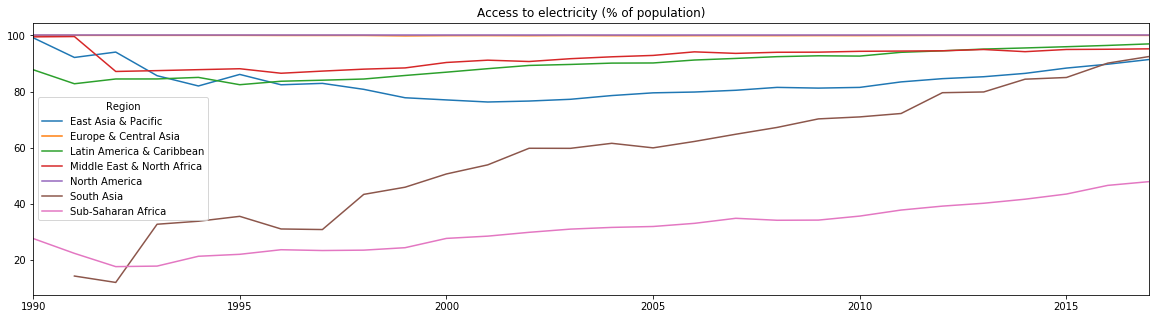

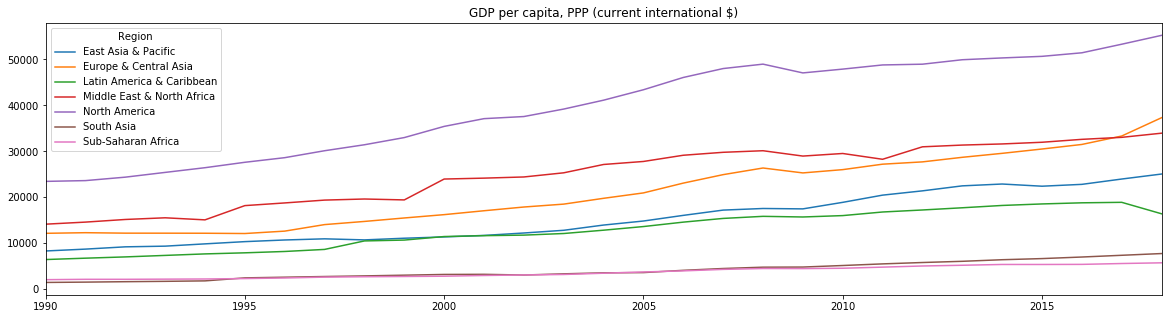

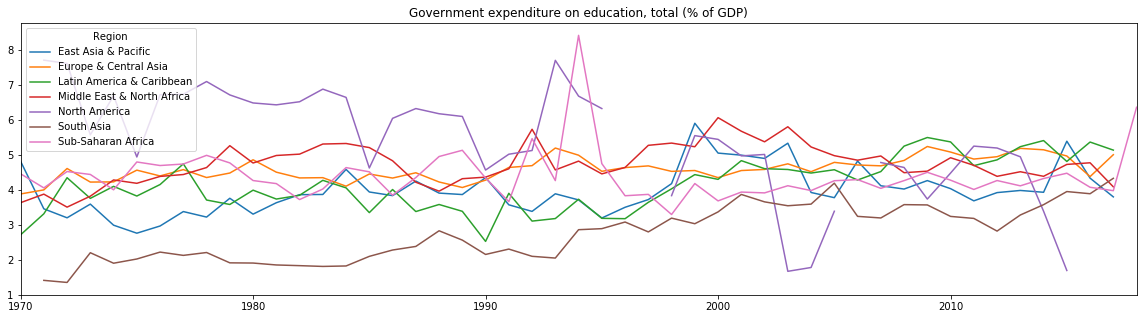

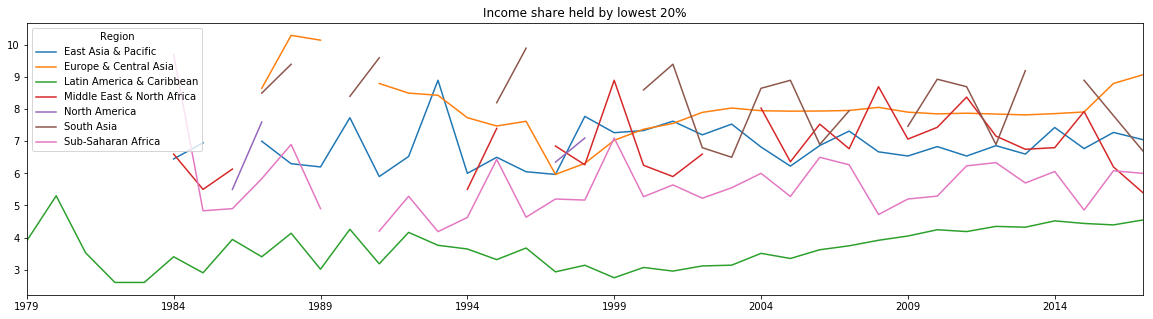

In [59]:
for df in [df_electric, df_gdp_pc, df_eduspend, df_income20]:
    df_clean = edstats.append_region(df.dropna(axis=1, how='all'), df_country)
    df_clean.groupby('Region').mean().transpose().plot(figsize=(20, 5), title=df['Indicator Name'].unique()[0]);

There are a few trends that we can observe from the visualization of the data:

* Percentage of population with access to electricity has drastically improved over last 30 years
* Sub-saharan Africa only 40% have currently access to electricty
* The curves for income and education expenditure appear to be spotty (meaning that the data is not collected for all intermediary years)
* Goverment expenditure on education shows no clear trend, but rather seems similar for all countries

In order to get a better understanding of the goverment expenditure, lets take a look at the 

In [61]:
# clean all the data
df_elc_clean = edstats.append_region(df_electric.dropna(axis=1, how='all'), df_country)
df_gdp_clean = edstats.append_region(df_gdp.dropna(axis=1, how='all'), df_country)
df_gdppc_clean = edstats.append_region(df_gdp_pc.dropna(axis=1, how='all'), df_country)
df_eduspend_clean = edstats.append_region(df_eduspend.dropna(axis=1, how='all'), df_country)
df_income20_clean = edstats.append_region(df_income20.dropna(axis=1, how='all'), df_country)

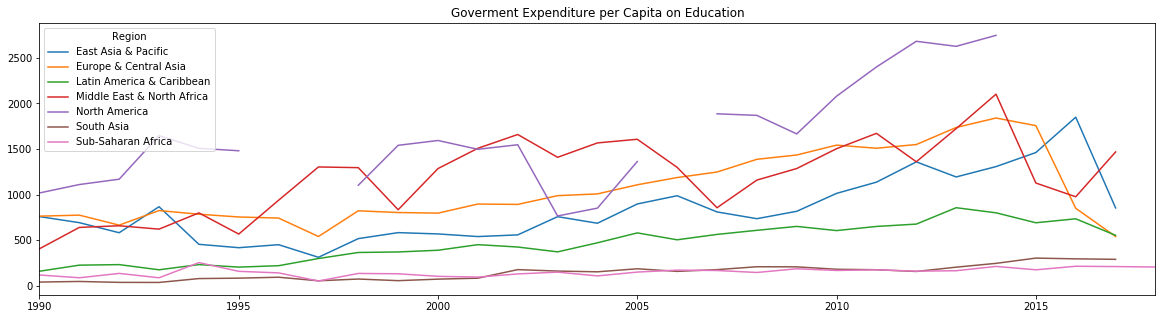

In [72]:
# combine 
df_eduspend_total = pd.merge(df_eduspend_clean[['Country Code']], df_gdppc_clean, on="Country Code")
df_tmp = df_eduspend_clean.iloc[:, 4:-1].combine(df_eduspend_total.iloc[:, 4:-1], lambda s1, s2: (s1/100)*s2, overwrite=True).dropna(axis=1, how='all')
df_eduspend_total = pd.concat([df_eduspend_clean[['Country Code', 'Country Name', 'Region']], df_tmp], axis=1)

#df_eduspend_clean
df_eduspend_total.groupby('Region').mean().transpose().plot(figsize=(20, 5), title='Goverment Expenditure per Capita on Education');
#df_eduspend_total.iloc[:, 4:-1]

From this combined data, we starting to see a clearer picture of the indicator. Countries in `North America` (i.e. US and Canada) appear to have a much higher total education expenditure per capita. Investments in `South Asia` and `Sub-Saharan Africa` on the other hand appear to be very low.
There is also a notable down-turn for the Europe expenditure from 2015 onwards. On reason for this might be adding of more countries in which the indicator is measured.

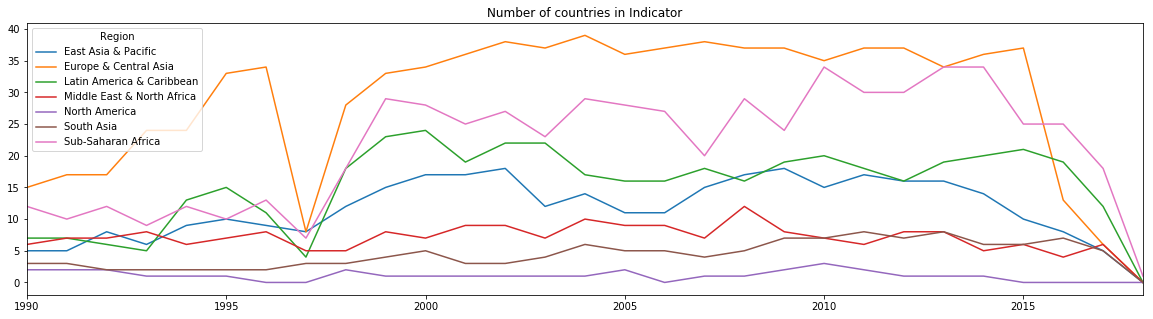

In [77]:
df_eduspend_total.groupby('Region').count().iloc[:, 2:].transpose().plot(figsize=(20, 5), title='Number of countries in Indicator');

From the analysis we can see, that it is actually the other way around: There are significantly less countries with relevant datapoints from 2015 onward. However, we can also see that the data is rather stable between 2000 and 2015, which will be the range we use for further analysis. (Another option would be to interpolate the missing values, as the indicators are seemingly not collected in every country for every year).

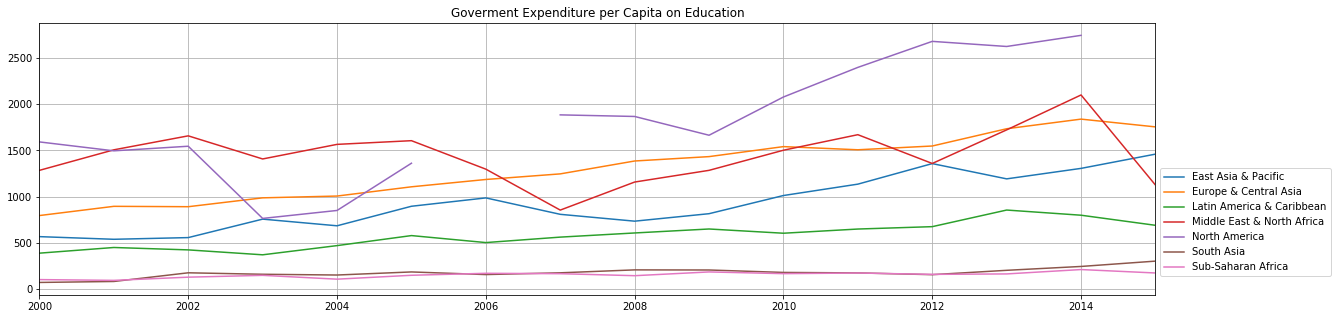

In [96]:
# select data for the relevant time frame
df_eduspend_total_sub = pd.concat([df_eduspend_total.iloc[:, :3], df_eduspend_total.iloc[:, 13:-3]], axis=1)

# plot data
fig, ax = plt.subplots()
df_eduspend_total_sub.groupby('Region').mean().transpose().plot(figsize=(20, 5), title='Goverment Expenditure per Capita on Education', ax=ax, grid=True);
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='lower left', bbox_to_anchor=(1., .05, .0, .0));

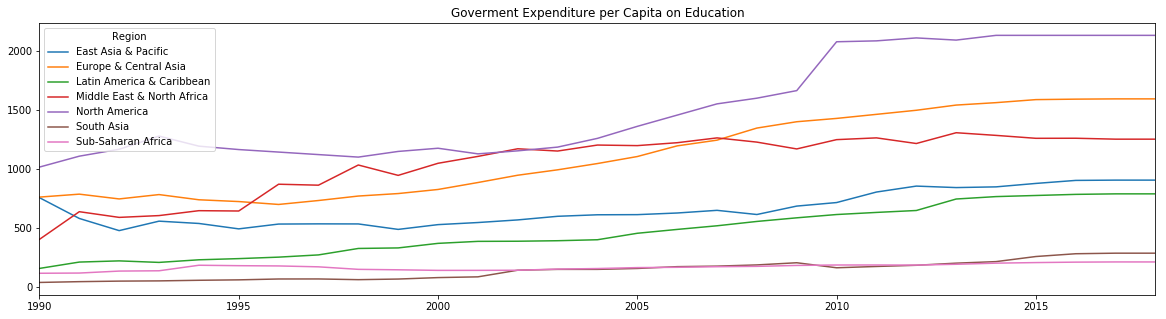

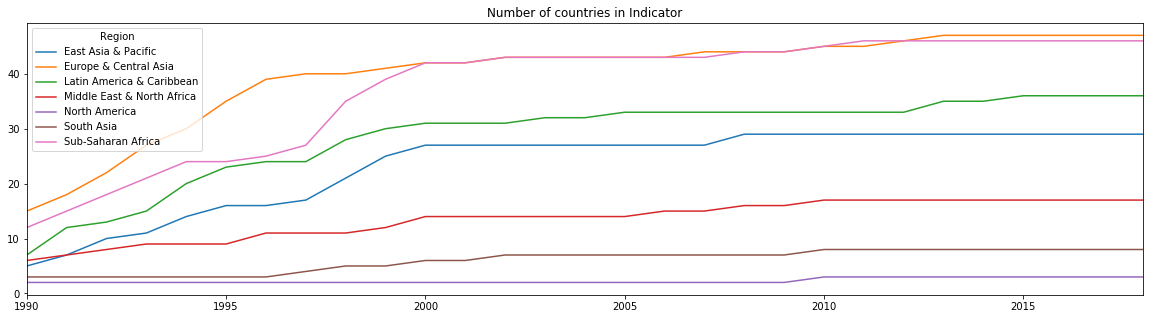

In [111]:
# interpolate the education data
df_eduspend_total_ip = pd.concat([
    df_eduspend_total.iloc[:, :3],
    df_eduspend_total.iloc[:, 3:].interpolate(method='linear', axis=1),
], axis=1)

df_eduspend_total_ip.groupby('Region').mean().transpose().plot(figsize=(20, 5), title='Goverment Expenditure per Capita on Education');
df_eduspend_total_ip.groupby('Region').count().iloc[:, 2:].transpose().plot(figsize=(20, 5), title='Number of countries in Indicator');

## Correlation to skill proficiency

Next, we will look at the actual correlation to skill proficiency with the economic factors:

* Electricity
* GDP per Captia
* Education Expenditure per Capita

We will use the interpolated data for the combination to ensure valid data for the year 2012 for as much countries as possible.

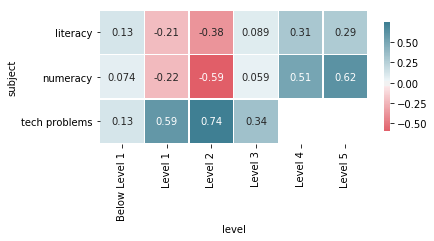

In [138]:
df_eduspend12 = df_eduspend_total_ip[['Country Code', 'Country Name', '2012']].dropna(axis=0, how='any')
df_ind12 = pd.merge(df_12, df_eduspend12, left_on='country_code', right_on='Country Code')\
    [['country_name', 'country_code', 'region', 'subject', 'level', 'gender', 'ppl_perc', 'edu_length', '2012']]\
    .rename(columns={'2012': 'value'})

# check the correlation for the different value combinations
combs = df_ind12.groupby(['subject', 'level', 'gender']).sum().index.tolist()
ds = []
for sub, lvl, gnd in combs:
    df_tmp = df_ind12[(df_ind12['subject'] == sub) & (df_ind12['level'] == lvl) & (df_ind12['gender'] == gnd)]
    corr = df_tmp['ppl_perc'].corr(df_tmp['value'])
    ds.append([sub, lvl, gnd, corr])
df_corr = pd.DataFrame(ds, columns=['subject', 'level', 'gender', 'corr'])
df_corr = df_corr[(df_corr['gender'] == 'Total') & (df_corr['level'].isin(['Below Level 1', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5']))].pivot(index='subject', columns='level', values='corr')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);